In [1]:
import gym
import math
import random
import time
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make('LunarLander-v2')
# env = gym.make("LunarLander-v2", render_mode="human")

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Replay Memory


In [2]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, tup):
        """Save a transition"""
        self.memory.append(tup)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [4]:
class Trainer:
    def __init__(self, model, learning_rate) -> None:
        self.model : DQN = model.to(device)
    
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss().to(device)
        # self.loss_fn = nn.SmoothL1Loss().to(device)

    def predict(self, state, no_grad=False):
        state = torch.tensor(state).to(device)
        
        if no_grad:
            with torch.no_grad():
                return self.model(state)
        else:
            return self.model(state)
    
    def train(self,y, y_):

        self.optimizer.zero_grad()    
        self.loss = self.loss_fn(y, y_).float()
        self.loss.backward()
        self.optimizer.step()
        
        return self.loss.item()



In [5]:
class Agent:
    def __init__(self, 
                 env:gym.Env, 
                 memory, 
                 trainer,
                 epsilon=50.,
                 BATCH_SIZE=128,
                 GAMMA=0.99) -> None:
        
        self.env = env
        self.memory : ReplayMemory = memory
        self.trainer: Trainer = trainer

        # parameters 
        self.epsilon = epsilon
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA

        # train parameters
        self.LOSS = []
        self.REWARDS = []
        
    
    def replay(self):
        # st = time.time()
        if len(self.memory)>=self.BATCH_SIZE:
            samples = self.memory.sample(self.BATCH_SIZE) # state, action,reward, new_state, terminated 
            
            
            # batch of states and new states
            batch_state = [sample[0] for sample in samples]
            batch_new_state = [sample[3] for sample in samples]
          
            batch_state = torch.tensor(batch_state)
            batch_new_state = torch.tensor(batch_new_state)

            y = self.trainer.predict(batch_state.to(device)) # y : predicted q values
            q_values = [] # q_values :  list for estimated target q value
            # batch prediction for next state (to improve train speed)
            q_values_next = self.trainer.predict(batch_new_state.to(device))
            
            # target q value estimation
            for  i, sample in enumerate(samples):
                _, action,reward, _, terminated = sample
                q_value = y[i].clone()
                
                if terminated:
                    q_value[action] = reward
                else:
                    q_value[action] = reward + self.GAMMA*q_values_next[i].max()

                q_values.append(q_value)  
                
        else: 
            return
        
        q_values = torch.stack(q_values).to(device)

        loss = self.trainer.train(y, q_values) # predicted values & estimated target q values

        return loss

    def get_exploration_rate(self, episode, epsilon):
     
        """
        Get the exploration_rate given an episode subject to decay (epsilone)

        inputs:
        -------
            e: a given episode
        return:
        -------
            a learning or an exploration rate
         """
        return max(0.1, min(1., 1. - np.log10((episode + 1) / epsilon)))
    
    def get_action(self, state, exploration_rate):
        # print(exploration_rate)
        if (np.random.random() < exploration_rate):
            return self.env.action_space.sample()
        else:
        # Choose greedily the action which gives the highest expected reward
        # given the current state
            return torch.argmax(self.trainer.predict(state)).item()

    def train(self, EPISODES):
        for e in range(1, EPISODES+1):
            state, _ = env.reset()
            terminated = False
            truncated = False
            total_reward = 0
            total_loss = 0
            episode_len = 0
            while not any([terminated, truncated]):
                rate = self.get_exploration_rate(episode=e, epsilon=self.epsilon)
                action = self.get_action(state, rate)
                new_state, reward, terminated, truncated, _ = env.step(action)
                
                self.memory.push((state, action,reward,new_state, terminated))   
                total_reward +=reward
                # update old state for new step
                state = new_state
                # replay memory to train DQN model
                loss = self.replay()
                if loss != None:
                    total_loss += loss
                episode_len += 1
            
            print(f" EPISODE {e}|{EPISODES} reward {total_reward} | loss: {total_loss}", end="\r")
            # print(f" EPISODE {e}|{EPISODES} reward {total_reward} | replay time {replay_end-replay_start:.3f}")
                
            if loss != None:
                self.LOSS.append(total_loss/episode_len)
                self.REWARDS.append(total_reward)
                
            if e%100==0:
                print(f"EPISODE {e}|{EPISODES} {total_reward} | Loss {loss}")
      
        print("Training Ends")
        
    def play(self):
        state, _ = env.reset()
        terminated = False
        truncated = False
        total_reward = 0
        episode_len = 0
        while not any([terminated, truncated]):
            # action = self.get_action(state, exploration_rate=-1)
            action = torch.argmax(self.trainer.predict(state, no_grad=True)).item()
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward +=reward
            episode_len += 1
            
        print("REWARD", total_reward, "FRAMES", episode_len)


In [6]:
trainer = Trainer(model=DQN(n_actions=env.action_space.n,n_observations=env.observation_space.shape[0]),
                  learning_rate=0.001)

In [7]:
agent = Agent(env=env,
            trainer=trainer,
            memory=ReplayMemory(10000),
            epsilon=100)

In [8]:
history = agent.train(1000)

c:\Users\pritom52251.WHILDC\AppData\Local\miniconda3\envs\RLml\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\pritom52251.WHILDC\AppData\Local\Temp\ipykernel_2728\2977513452.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  batch_state = torch.tensor(batch_state)
C:\Users\pritom52251.WHILDC\AppData\Local\Temp\ipykernel_2728\2661900199.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).to(device)


EPISODE 100|1000 -394.719959057006 | Loss 1.63266849517822271337499622
EPISODE 200|1000 -120.07887932215885 | Loss 0.3281635940074920725027466
EPISODE 300|1000 -48.29323870074887 | Loss 0.204284816980361948878975966
EPISODE 400|1000 4.925451485892495 | Loss 0.266745716333389338042068566
EPISODE 500|1000 150.0124841228523 | Loss 0.224610239267349249929976527
EPISODE 600|1000 32.79422176191011 | Loss 0.974460840225219702458787078
EPISODE 700|1000 207.0219264061269 | Loss 0.242427259683609137046456354
EPISODE 800|1000 275.1622977031606 | Loss 0.202525973320007329121561136
EPISODE 900|1000 -50.77514334051599 | Loss 0.41526859998703003696613386
EPISODE 1000|1000 173.24212815874017 | Loss 0.2915417551994324578214645
Training Ends


In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [25]:
env.close()
env = gym.make("LunarLander-v2", render_mode="human")
# env = gym.make("LunarLander-v2")
agent.env = env

In [26]:
for i in range(10):
    agent.play()

c:\Users\pritom52251.WHILDC\AppData\Local\miniconda3\envs\RLml\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


REWARD -16.528075085946696 FRAMES 206
REWARD 242.7578814755821 FRAMES 303
REWARD 240.71254159999867 FRAMES 572
REWARD 268.29730397633557 FRAMES 267
REWARD 154.56799988162723 FRAMES 1000
REWARD -66.18460735123656 FRAMES 137
REWARD -51.407678182756854 FRAMES 133
REWARD -19.749377538689515 FRAMES 134
REWARD 170.12973955212362 FRAMES 297
REWARD -100.52672103000512 FRAMES 192


In [19]:
env.close()

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

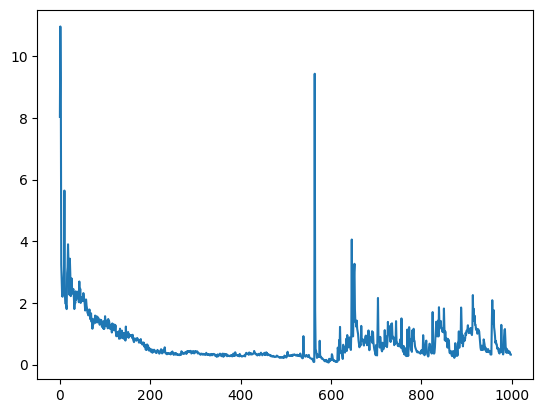

In [11]:
# plt.figure(figsize=(16,16))
plt.plot(agent.LOSS)
# plt.axes()

Text(0, 0.5, 'REWARDS')

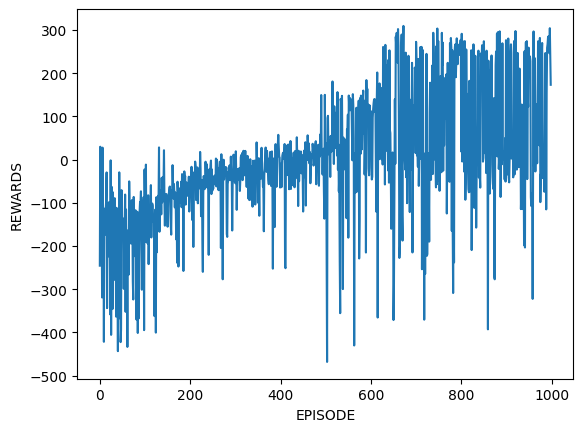

In [12]:
plt.plot(agent.REWARDS)
plt.xlabel("EPISODE")
plt.ylabel("REWARDS")

In [14]:
np.corrcoef(agent.LOSS, agent.REWARDS)

array([[ 1.        , -0.24756406],
       [-0.24756406,  1.        ]])

In [23]:
# import seaborn as sns

In [22]:
# Tensor_a = trainer.model.layer1.weight.clone()
# Tensor_b = trainer.model.layer2.weight.clone()

In [ ]:
# plt.figure(figsize=(12,10))
# sns.heatmap(Tensor_a.cpu().detach().numpy(), linewidth=0.5)

In [21]:
# plt.figure(figsize=(12,10))
# sns.heatmap(Tensor_b.detach().cpu().numpy(), linewidth=0.5)

In [15]:
torch.save(agent.trainer.model.state_dict(), f"model/model_{int(time.time())}.pt")